# Figure 6

Temperature and salinity anomalies in depth-longitude space

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import gsw
import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.lines import Line2D
import matplotlib.path as mpath

import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35475,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:43309,Total threads: 4
Dashboard: /proxy/38177/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:44465,


In [3]:
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

### Preplotting - data and functions.

Read in depth-longitude anomaly data

In [4]:
control = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091.nc')
ssp245 = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091_ssp245.nc')
ssp245mw = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091_ssp245_mw.nc')
ssp585 = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ryf9091_ssp585.nc')
ssp585mw = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/shelf_lon-z/shelf_lon-z_MEAN_01deg_jra55v13_ssp585_windthermalmw.nc')

Add density to datasets. 

In [5]:
ssp245['sig1'] = gsw.density.sigma1(ssp245['salt'], ssp245['temp'])
ssp245mw['sig1'] = gsw.density.sigma1(ssp245mw['salt'], ssp245mw['temp'])
ssp585['sig1'] = gsw.density.sigma1(ssp585['salt'], ssp585['temp'])
ssp585mw['sig1'] = gsw.density.sigma1(ssp585mw['salt'], ssp585mw['temp'])

Read in bottom data

In [6]:
outdir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/bottom_values/'
ds_ctrl = xr.open_dataset(outdir + 'control_temp_salt.nc')
ds_ssp245mw = xr.open_dataset(outdir + 'ssp245mw_temp_salt.nc')

Calculate bottom anomalies. 

In [7]:
bottom_temp_anom = (ds_ssp245mw.temp - ds_ctrl.temp).mean('time').compute()
bottom_salt_anom = (ds_ssp245mw.salt - ds_ctrl.salt).mean('time').compute()

Miscellaneous plotting data. 

In [8]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ctrl = '01deg_jra55v13_ryf9091'

# topography data for plotting:
ht = cc.querying.getvar(ctrl,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

Miscellaneous plotting functions. 

In [9]:
def plot_vars(axes, ds, t, scenario):
    cbA = axes[0].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.age.isel(time = t), 
                       cmap = cmo.curl, vmin=-60, vmax=60)
    cbT = axes[1].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.temp.isel(time = t), 
                       cmap = cmo.balance, vmin=-1.5, vmax=1.5)
    cbS = axes[2].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.salt.isel(time = t), 
                       cmap = cmo.delta, vmin=-0.4, vmax=0.4)
    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim([0,1300])
        ax.invert_yaxis()
        ax.text(-270, 1200, f'{scenario}', fontsize=14, fontweight='bold', color='k',
                bbox=dict(facecolor='w', edgecolor='dimgrey', boxstyle='round,pad=0.2'))
        if i > 0:
            ax.set_yticklabels([])

    return cbA, cbT, cbS

def colorbar_horz(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'horizontal',extend = 'both')
    cbar.set_label(label,fontsize=fs,labelpad=6)
    cbar.ax.tick_params(labelsize=fs, labeltop=True)
    return cbar

def plot_land_mask(axes):
     for i, ax in enumerate(axes.flatten()):
         ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors=['k','grey'],linewidths=0.8,)
         ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)
         ax.set_ylim([-79,-60])
         if i > 0:
            ax.set_yticklabels([])

def plot_vars_timemean(axes, ds, cntl, scenario):
    cntl_temp = cntl.temp.mean(dim='time').where(cntl.temp.mean(dim='time') != 0., np.nan)
    cntl_salt= cntl.salt.mean(dim='time').where(cntl.salt.mean(dim='time') != 0., np.nan)
    cbT = axes[0].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.temp.mean(dim='time') - cntl_temp, 
                       cmap = cmo.balance, vmin=-1.5, vmax=1.5)
    cbS = axes[1].pcolormesh(ds.xt_ocean, ds.st_ocean, ds.salt.mean(dim='time') - cntl_salt, 
                       cmap = cmo.delta, vmin=-0.6, vmax=0.6)
    
    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim([0,1000])
        ax.invert_yaxis()
        ax.text(-274, 900, f'{scenario}', fontsize=16, fontweight='bold', color='dimgrey',
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
        if i > 0:
            ax.set_yticklabels([])

    return cbT, cbS

### Plot figure. 

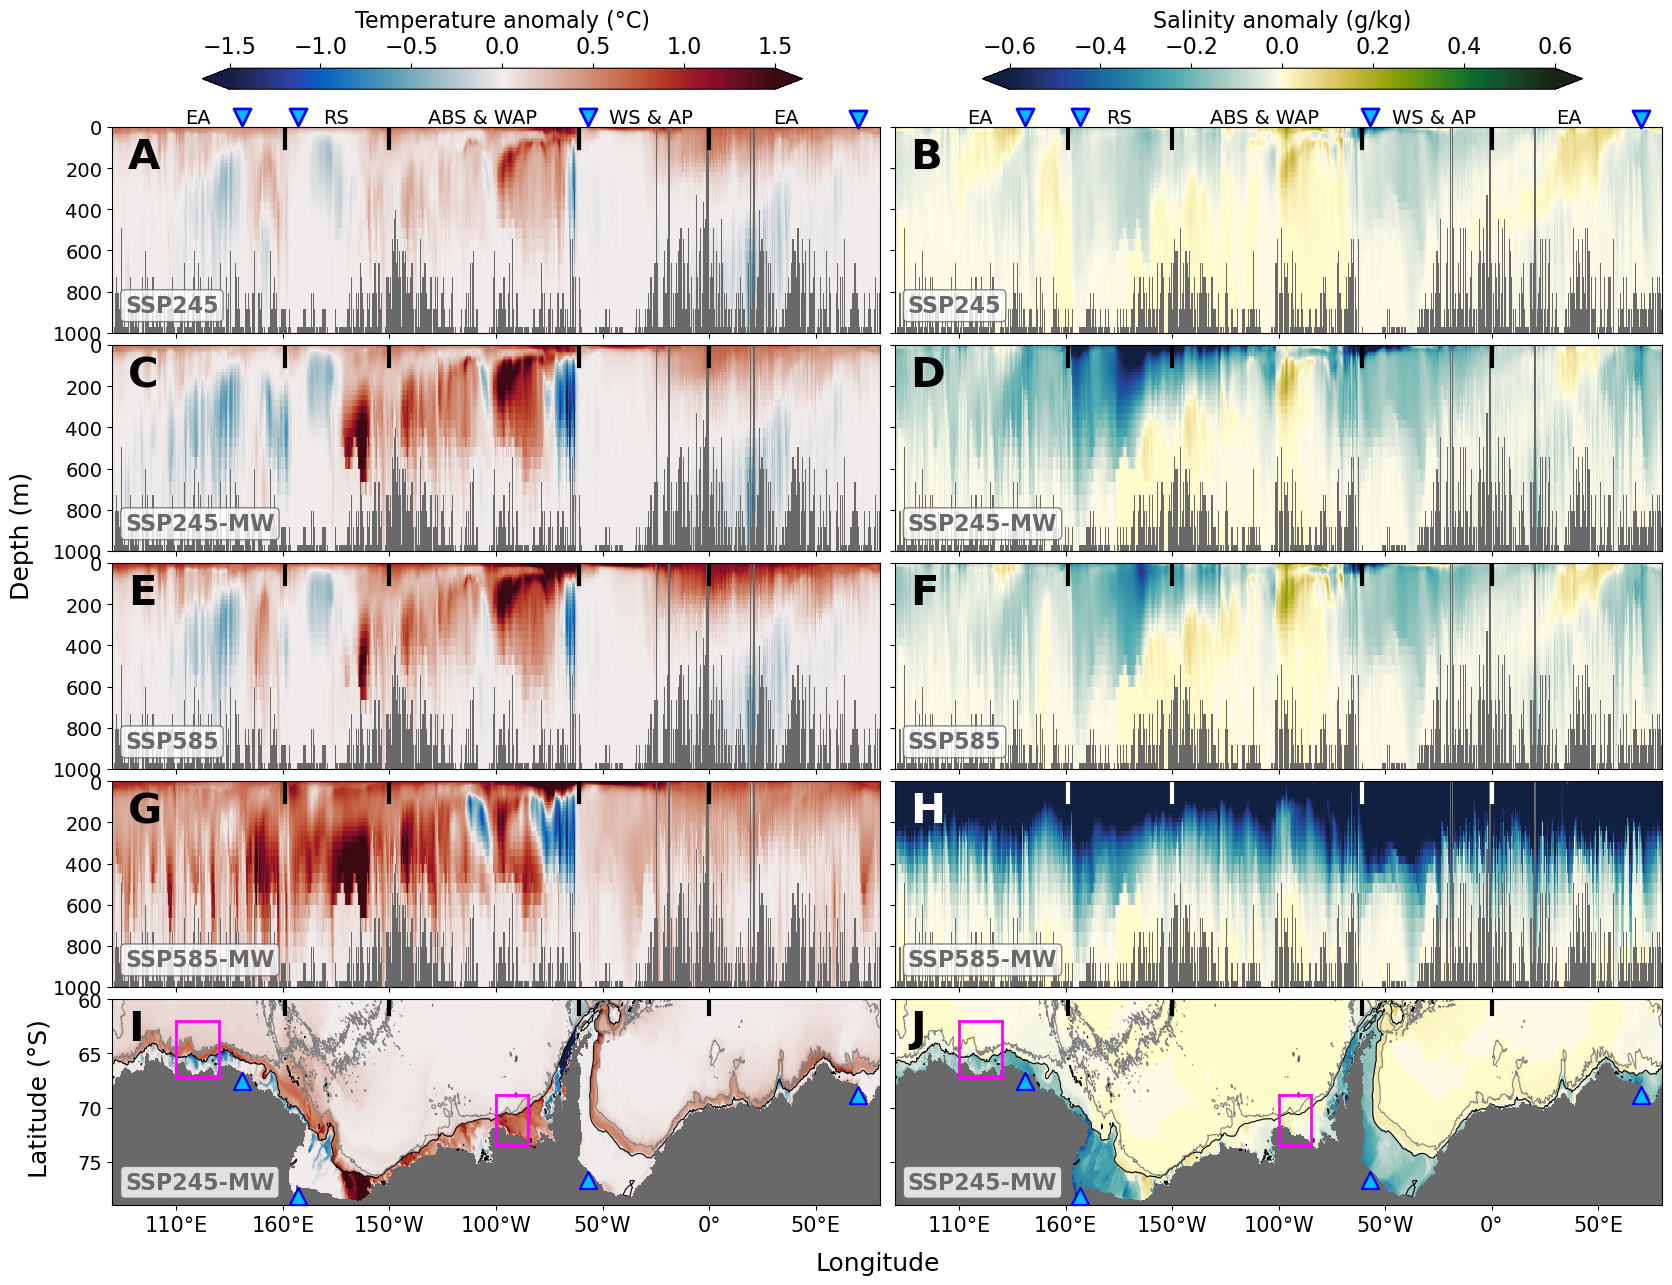

CPU times: user 10.6 s, sys: 3.39 s, total: 14 s
Wall time: 12.8 s


In [10]:
%%time
plt.rcParams.update({'font.size': 14})
fig,axes = plt.subplots(5, 2, figsize=(20, 14), sharex=True, 
                            gridspec_kw = {'wspace':0.02, 'hspace':0.06},height_ratios=[1,1,1,1,1])

# plot depth-longitude anomalies
plot_vars_timemean(axes[0,:], ssp245.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP245')
plot_vars_timemean(axes[1,:], ssp245mw.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP245-MW')
plot_vars_timemean(axes[2,:], ssp585.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP585')
cbT, cbS = plot_vars_timemean(axes[3,:], ssp585mw.sel(time=slice('2160-01','2164-12')), control.sel(time=slice('2160-01','2164-12')), 'SSP585-MW')

#cbar = colorbar_horz(cbT, [0.17, 0.89, 0.3, 0.015],'Temperature anomaly (\u00b0C)')
cbar = colorbar_horz(cbT, [0.17, 0.907, 0.3, 0.015],'Temperature anomaly (\u00b0C)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
#cbar = colorbar_horz(cbS, [0.56, 0.89, 0.3, 0.015],'Salinity anomaly (g/kg)')
cbar = colorbar_horz(cbS, [0.56, 0.907, 0.3, 0.015],'Salinity anomaly (g/kg)')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# plot spatial maps in I) and J)
plot_land_mask(axes[4,:])
# plot bottom anomalies
axes[4,0].pcolormesh(bottom_temp_anom.xt_ocean, bottom_temp_anom.yt_ocean, bottom_temp_anom, 
                    cmap = cmo.balance, vmin=-1.5, vmax=1.5)
axes[4,1].pcolormesh(bottom_salt_anom.xt_ocean, bottom_salt_anom.yt_ocean, bottom_salt_anom, 
                    cmap = cmo.delta, vmin=-0.6, vmax=0.6)
axes[4,0].text(-274, -77.5, 'SSP245-MW', fontsize=16, fontweight='bold', color='dimgrey',
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
axes[4,1].text(-274, -77.5, 'SSP245-MW', fontsize=16, fontweight='bold', color='dimgrey',
                bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
axes[4,0].set_yticks([-75, -70, -65, -60])
axes[4,0].set_yticklabels([75, 70, 65, 60])


# label subplots
labels = ['A','B','C','D','E','F','G','H','I','J']
for i, ax in enumerate(axes.flatten()):
    ax.set_facecolor('dimgrey')
    if i == 7:
        ax.text(0.02, 0.8, f'{labels[i]}',  c='w', fontsize=30, fontweight='bold', transform = ax.transAxes)
    else:
        ax.text(0.02, 0.8, f'{labels[i]}',  c='k', fontsize=30, fontweight='bold', transform = ax.transAxes)

    bounds = [-199, -150, -61, 0]
    if i < 8:
        for b, lon in enumerate(bounds):
            if i == 7:
                ax.plot([lon, lon],[0,100], c='w', lw=3)
            else:
                ax.plot([lon, lon],[0,100], c='k', lw=3)
        if i <= 1:
            tc = 'k'
            ax.text(-246, -20, 'EA',  c=tc, fontsize=14, clip_on=False)
            ax.text(30, -20, 'EA', c=tc,fontsize=14,)
            ax.text(-181, -20, 'RS', c=tc, fontsize=14,)
            ax.text(-132, -20, f'ABS & WAP',  c=tc, fontsize=14)
            ax.text(-47, -20, 'WS & AP', c=tc,fontsize=14)
    else:
        tc = 'k'
        for b, lon in enumerate(bounds):
            ax.plot([lon, lon],[-61.4,-60], c='k', lw=3)
        ax.set_xticklabels(['','110\u00b0E','160\u00b0E','150\u00b0W','100\u00b0W','50\u00b0W', '0\u00b0','50\u00b0E'], 
                           fontsize=15)

# plot axis labels
axes[2,0].text(-328, 150, 'Depth (m)', rotation=90, c=tc,fontsize=18)
axes[4,0].text(50, -85, 'Longitude', c=tc,fontsize=18)
axes[4,0].text(-320, -76, 'Latitude (\u00b0S)', rotation=90, c=tc,fontsize=18)

l,r,b,t,c,ls,lw = -230, -250, -67.2, -62, 'magenta','-', 2
axes[4,0].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [t,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [t,t], lw=lw, ls=ls, c=c)

l,r,b,t = -100, -85, -73.5, -68.8
axes[4,0].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,0].plot([l,r], [t,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,l], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([r,r], [b,t], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [b,b], lw=lw, ls=ls, c=c)
axes[4,1].plot([l,r], [t,t], lw=lw, ls=ls, c=c)


# mark locations of DSW formation sites
for i in range(2):
    axes[0,i].scatter(70, -40, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Prydz
    axes[0,i].scatter(-219, -50, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Adelie
    axes[0,i].scatter(-193, -50, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Ross
    axes[0,i].scatter(-57, -50, marker='v', s=150, c='deepskyblue', edgecolors='b', linewidths=2, clip_on=False) # Weddell

    axes[4,i].scatter(70, -68.8, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Prydz
    axes[4,i].scatter(-219, -67.5, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Adelie
    axes[4,i].scatter(-193, -78.2, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Ross
    axes[4,i].scatter(-57, -76.7, marker='^', s=150, c='deepskyblue', edgecolors='b', linewidths=1.6, clip_on=False, zorder=10) # Weddell

# save figure
# fig.savefig('../figs/Fig06.jpg', dpi=300, bbox_inches='tight')

plt.show()